## **CNN para Classificação de Pneumonia com TransferLearning**


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils import class_weight
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'matplotlib'

**Preparação do dataset**

Verificando diretório
/ Controle da quantidade de arquivos
/ Pré processamento e parametros da imagem /
Visualização das imgs e gráficos

In [8]:
data_dir = Path('chest_xray')
conjuntos = ['train', 'val', 'test']
categorias = ['NORMAL', 'PNEUMONIA']

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

contagens = {}

for conjunto in conjuntos:
    for categoria in categorias:
        pasta = data_dir / conjunto / categoria
        qtd = len(list(pasta.glob('*.jpeg')))
        contagens[f"{conjunto}_{categoria.lower()}"] = qtd

for conjunto in conjuntos:
    print(f"\n{conjunto.upper()}:")
    for categoria in categorias:
        chave = f"{conjunto}_{categoria.lower()}"
        print(f"{categoria}: {contagens[chave]} imagens")

# Totais por categoria (somando train + val + test)
normal_imgs_count = sum(contagens[k] for k in contagens if "normal" in k)
pneumonia_imgs_count = sum(contagens[k] for k in contagens if "pneumonia" in k)

print(f"\n Imagens diretório NORMAL: {normal_imgs_count}, "
      f"Imagens no diretório PNEUMONIA: {pneumonia_imgs_count}")

# Total imgs
total = normal_imgs_count + pneumonia_imgs_count
print(f" Total geral de imagens: {total}")

# Configurações do dataset
image_size = (224, 224)
batch_size = 32


TRAIN:
NORMAL: 1341 imagens
PNEUMONIA: 3875 imagens

VAL:
NORMAL: 8 imagens
PNEUMONIA: 8 imagens

TEST:
NORMAL: 234 imagens
PNEUMONIA: 390 imagens

 Imagens diretório NORMAL: 1583, Imagens no diretório PNEUMONIA: 4273
 Total geral de imagens: 5856


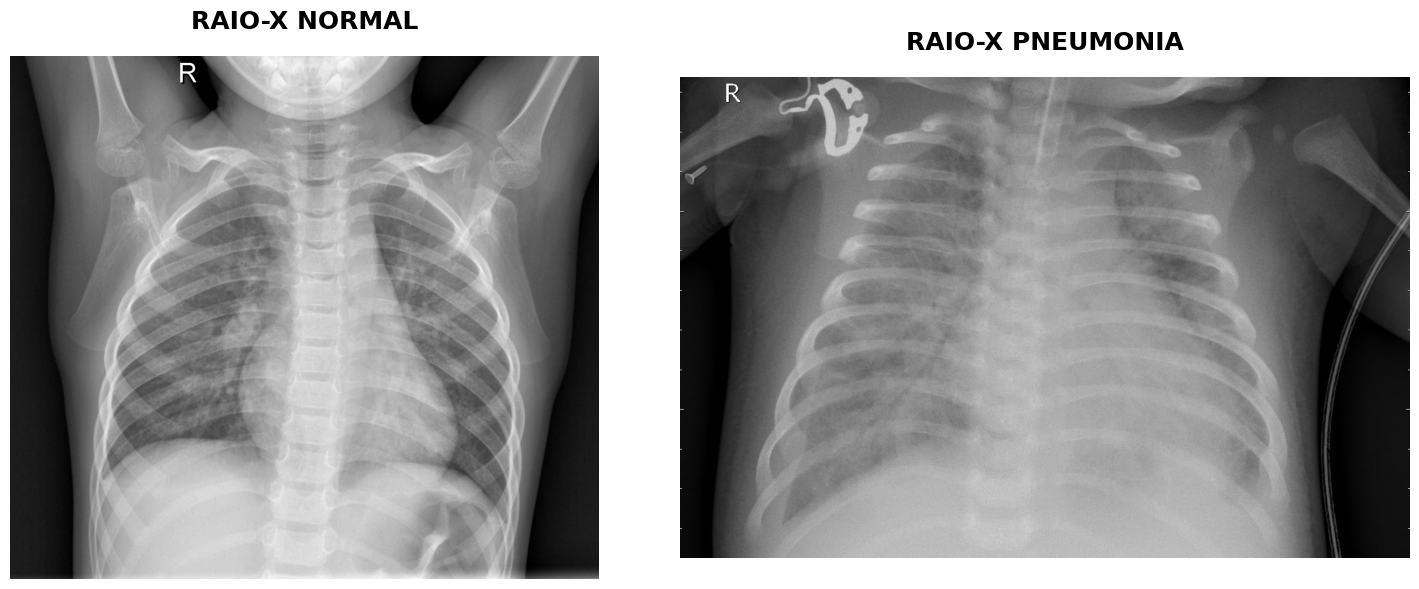

In [6]:
data_dir = Path('chest_xray')
train_dir = data_dir / 'train'

# Acha imagem nos diretorios
normal_dir = train_dir / 'NORMAL'
normal_imgs = list(normal_dir.glob('*.jpeg')) + list(normal_dir.glob('*.jpg')) + list(normal_dir.glob('*.png'))
normal_imgs.sort()
primeira_normal = normal_imgs[0] if normal_imgs else None

pneumonia_dir = train_dir / 'PNEUMONIA'
pneumonia_imgs = list(pneumonia_dir.glob('*.jpeg')) + list(pneumonia_dir.glob('*.jpg')) + list(pneumonia_dir.glob('*.png'))
pneumonia_imgs.sort()
primeira_pneumonia = pneumonia_imgs[0] if pneumonia_imgs else None

# Exibi as imagens
if primeira_normal and primeira_pneumonia:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    fig.patch.set_facecolor('white')
    
    # NORMAL
    img_normal = Image.open(primeira_normal)
    ax1.imshow(img_normal, cmap='gray')
    ax1.set_title('RAIO-X NORMAL', fontsize=18, fontweight='bold', pad=20)
    ax1.axis('off')
    
    # PNEUMONIA
    img_pneumonia = Image.open(primeira_pneumonia)
    ax2.imshow(img_pneumonia, cmap='gray')
    ax2.set_title('RAIO-X PNEUMONIA', fontsize=18, fontweight='bold', pad=20)
    ax2.axis('off')
    
    plt.tight_layout()
    
    plt.show()
else:
    print("Não foi possível encontrar as imagens necessárias")

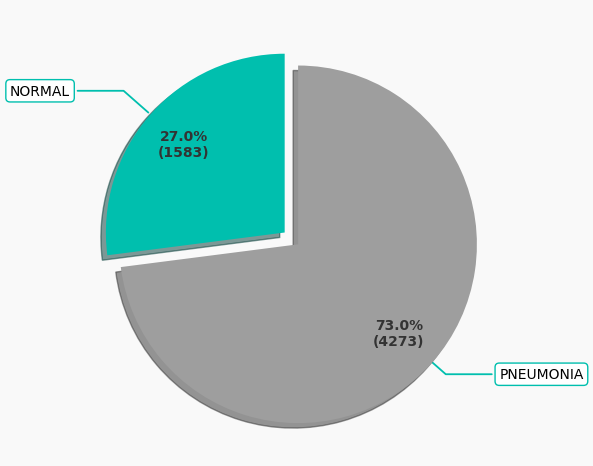

In [9]:
#GRÁFICO ENTRE AS CLASSES NORMAL E PNEUMONIA

labels = ["NORMAL", "PNEUMONIA"]
sizes = [normal_imgs_count, pneumonia_imgs_count]
explode = (0, 0.1)

# mostrar porcentagem + valor absoluto
def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"


plt.style.use("default")

fig, ax = plt.subplots(figsize=(6, 6), facecolor="#f9f9f9")
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,  # rótulos fora da pizza
    autopct=lambda pct: func(pct, sizes),
    pctdistance=0.75,
    startangle=90,
    colors=['#00bfae', "#9e9e9e"],
    shadow=True
)

# fora da pizza
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="#00bfae", lw=1)
kw = dict(arrowprops=dict(arrowstyle="-", color="#00bfae", lw=1.3),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i],
                xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, **kw)

# percentual + valores
plt.setp(autotexts, size=10, weight="bold", color="#333333")


ax.set_aspect('equal')  # mantém formato circular
plt.tight_layout()
plt.show()


**Balanceando o dataset**

Carrega imagens em batchs / tecnicas de aumento de dados(data augmentation) no treino/ Define classes e como serao usadas

In [ ]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print('Class indices:', train_generator.class_indices)


## **Construção do modelo com MobileNetV2**


VERIFICANDO GPU / APLICANDO TRANSFER LEARNING/ DADOS DA IMAGEM SHAPE(ALTURA,LARGURA,CANAL IMG) / HIPERPARAMETROS: CAMADAS ATIVAÇÃO,SAIDA ; POOLING; / CONGELANDO CAMADAS / TECNICAS BATCH E DROPOUT

In [ ]:
if tf.test.gpu_device_name():
    print('GPU encontrada: {}'.format(tf.test.gpu_device_name()))
else:
    print("Nenhuma GPU encontrada. Verifique as configurações do ambiente de execução.")

In [ ]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # fase 1: congelado

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

**TREINAMENTO**

Define callbacks: earlyStopping, reduce e model. (potencializar o treinamento evitar overfitting) / Calcula pesos / salva modelo .H5


In [ ]:
# Callbacks
checkpoint_path = 'mobilenetv2_best_phase1.h5'
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
mc = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# calcular pesos
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Pesos das classes:", class_weights)

# Treino congelado
train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size

history1 = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_steps),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=max(1, val_steps),
    callbacks=[es, rl, mc],
    class_weight=class_weights 
)

model.save('mobilenetv2_FASE1.h5')


## **Gráficos e resultados**

In [ ]:
#Gráfico de acuracia e loss
def plot_combined(h1, h2=None):
    hist = {}
    for k, v in h1.history.items():
        hist[k] = v.copy()
    if h2:
        for k, v in h2.history.items():
            hist[k].extend(v)

    epochs = range(1, len(hist['loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='Loss de treino')
    plt.plot(epochs, hist['val_loss'], label='Loss de Validação')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='Acurácia de treino')
    plt.plot(epochs, hist['val_accuracy'], label='Acurácia de validação')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_combined(history1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 683ms/step - accuracy: 0.9103 - auc: 0.9665 - loss: 0.2277
Test loss: 0.2277 - Test acc: 0.9103 - Test AUC: 0.9665
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 690ms/step
Confusion matrix:
 [[202  32]
 [ 24 366]]

Classification report:

              precision    recall  f1-score   support

      NORMAL       0.89      0.86      0.88       234
   PNEUMONIA       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



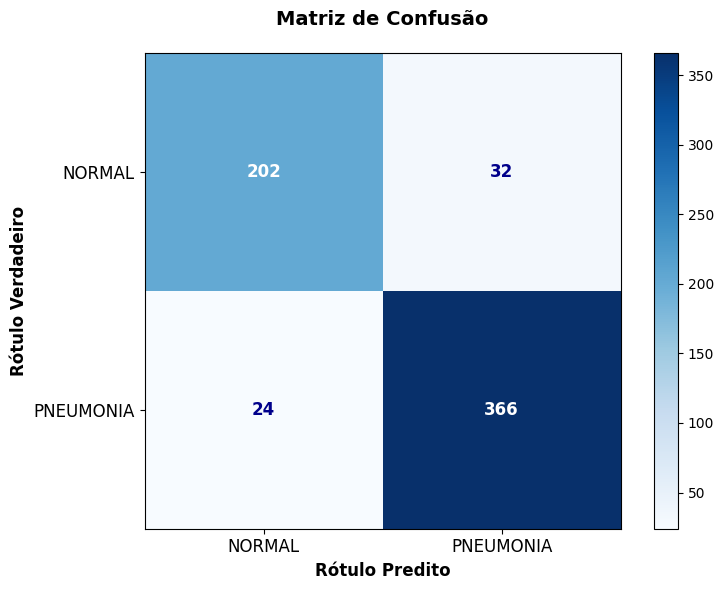

In [58]:
# Avaliação no conjunto de teste usando o melhor modelo da fase 2 (se existir) ou fase 1
best_path = 'mobilenetv2_best_FASE2.h5' if os.path.exists('mobilenetv2_best_FASE2.h5') else 'mobilenetv2_FASE1.h5'
best = load_model(best_path)

#valida métricas
test_steps = test_generator.samples // batch_size + 1
loss, acc, auc = best.evaluate(test_generator, steps=test_steps)
print(f'Test loss: {loss:.4f} - Test acc: {acc:.4f} - Test AUC: {auc:.4f}')

y_pred_prob = best.predict(test_generator, steps=test_steps)
y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)
y_true = test_generator.classes[:len(y_pred)]

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)
print('\nClassification report:\n')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# tabela matriz confusao
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão'):
    plt.figure(figsize=(8, 6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=12,
                 fontweight='bold',
                 color='white' if cm[i, j] > thresh else 'darkblue')
    
    plt.ylabel('Rótulo Verdadeiro', fontsize=12, fontweight='bold')
    plt.xlabel('Rótulo Predito', fontsize=12, fontweight='bold')
    plt.tight_layout()
    

    plt.grid(False)
    plt.show()

# chama FUNÇÃO
plot_confusion_matrix(cm, classes=list(test_generator.class_indices.keys()), normalize=False)

CURVA ROC / AUC

In [ ]:
# CURVA ROC/AUC - VERSÃO PROFISSIONAL
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba, title='Curva ROC - Detecção de Pneumonia'):
    plt.figure(figsize=(8, 6))
    
    # Calcula ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot da curva
    plt.plot(fpr, tpr, color='#2E86AB', linewidth=3, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='#A9A9A9', linestyle='--', linewidth=2, 
             label='Classificador Aleatório (AUC = 0.5)')
    
    # Configurações visuais
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12, fontweight='bold')
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    plt.legend(loc='lower right', fontsize=11, frameon=True, fancybox=True)
    
    plt.fill_between(fpr, tpr, alpha=0.1, color='#2E86AB')
    
    plt.text(0.6, 0.3, f'AUC = {roc_auc:.4f}', 
             fontsize=13, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    print(f"AUC Score: {roc_auc:.4f}")
    return roc_auc

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 661ms/step


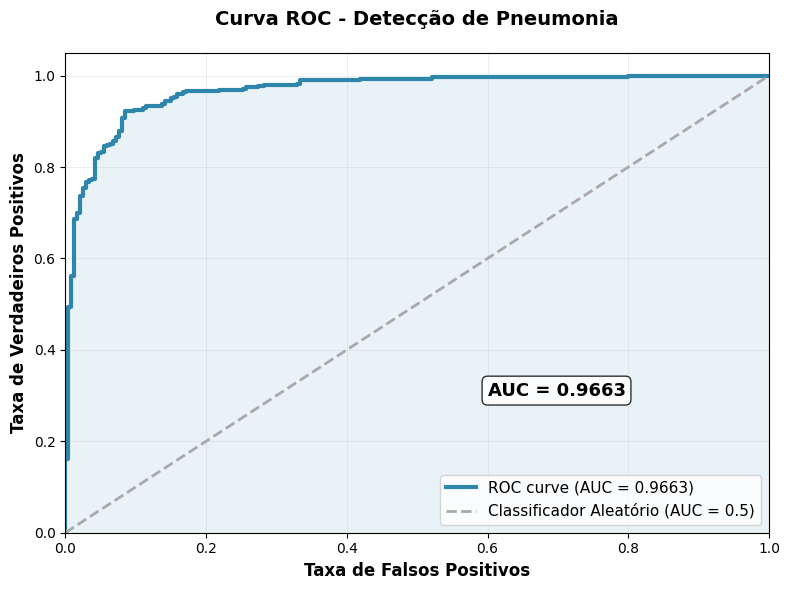

AUC Score: 0.9663
Total de amostras: 624
Distribuição dos labels: (array([0, 1], dtype=int32), array([234, 390]))
Probabilidades - Min: 0.0000, Max: 1.0000
AUC esperado: ~0.9602


In [57]:
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator).ravel()

# Plot da curva ROC profissional
plot_roc_curve(y_true, y_pred_proba)

# DETALhes
print(f"Total de amostras: {len(y_true)}")
print(f"Distribuição dos labels: {np.unique(y_true, return_counts=True)}")
print(f"Probabilidades - Min: {y_pred_proba.min():.4f}, Max: {y_pred_proba.max():.4f}")
print(f"AUC esperado: ~0.9602")

## TESTES DO MODELO

In [56]:
from keras.models import load_model

model = load_model('mobilenetv2_FASE1.h5')

print("Modelo 'mobilenetv2_FASE1.H5' carregado!")


Modelo 'mobilenetv2_FASE1.H5' carregado!


In [4]:
model = tf.keras.models.load_model('mobilenetv2_FASE1.h5')

🔍 Classificando 600

Processadas 300 imagens
Processadas 600 imagens

📊 RESULTADOS FINAIS
✅ Acertos: 541
❌ Erros: 83
Acurácia: 86.70%

🔍 Exibindo alguns exemplos de classificação:


C:\Users\Pizolato\AppData\Local\Temp\ipykernel_13288\3244729623.py:102: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pizolato\AppData\Local\Temp\ipykernel_13288\3244729623.py:102: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Pizolato\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Pizolato\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


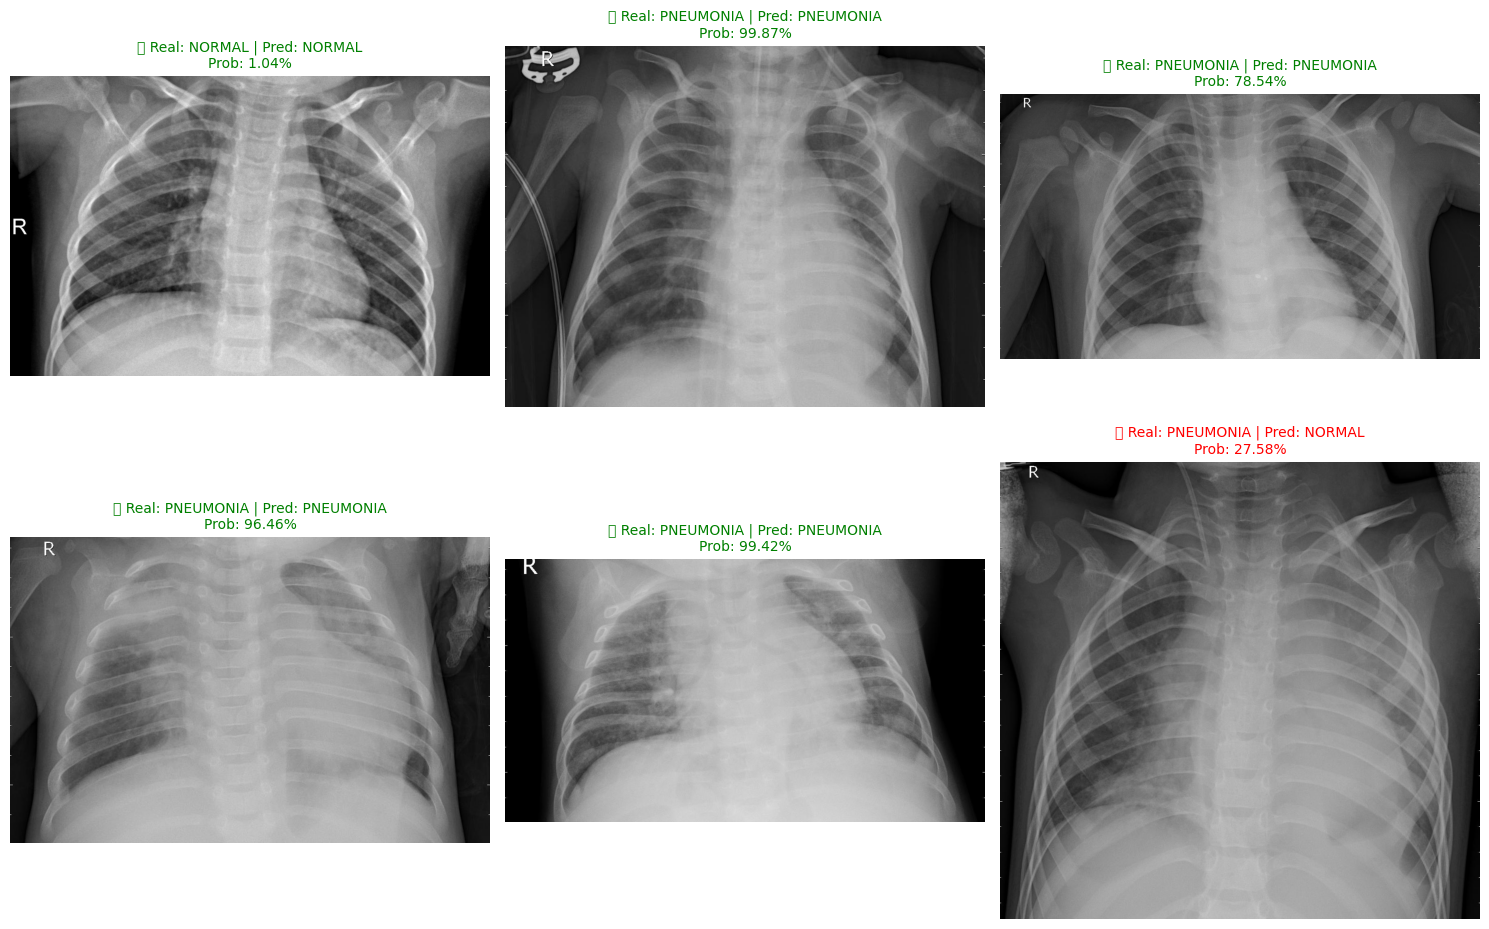


Estatísticas por classe:
PNEUMONIA: 335/390 corretas (85.90%)
NORMAL: 206/234 corretas (88.03%)


In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

# Caminho da pasta de teste
test_dir = r'chest_xray/test'

# Pega todas as imagens das duas classes
normal_imgs = [os.path.join(test_dir, 'NORMAL', f) for f in os.listdir(os.path.join(test_dir, 'NORMAL')) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
pneumonia_imgs = [os.path.join(test_dir, 'PNEUMONIA', f) for f in os.listdir(os.path.join(test_dir, 'PNEUMONIA')) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Junta e escolhe 100 aleatórias (50 de cada classe para balancear)
amostras_normal = random.sample(normal_imgs, min(234, len(normal_imgs)))
amostras_pneumonia = random.sample(pneumonia_imgs, min(390, len(pneumonia_imgs)))
amostras = amostras_normal + amostras_pneumonia

# Embaralha as amostras
random.shuffle(amostras)

# Contadores
acertos = 0
erros = 0
resultados = []

print("🔍 Classificando 600\n")

# Avaliar cada imagem
for i, caminho_imagem in enumerate(amostras):
    try:
        # Carregar e preparar a imagem (redimensiona mesmo que seja pequena)
        img = Image.open(caminho_imagem).convert('RGB')
        img_resized = img.resize((224, 224))  # Garante o tamanho correto
        img_array = image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Fazer a previsão
        predicao = model.predict(img_array, verbose=0)
        prob = float(predicao[0][0])
        classe_pred = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'

        # Determinar classe verdadeira com base no caminho
        classe_real = 'PNEUMONIA' if 'PNEUMONIA' in caminho_imagem else 'NORMAL'

        # Verificar se acertou
        acertou = classe_pred == classe_real
        if acertou:
            acertos += 1
        else:
            erros += 1

        # Armazenar resultado
        resultados.append({
            'arquivo': os.path.basename(caminho_imagem),
            'real': classe_real,
            'predito': classe_pred,
            'probabilidade': prob,
            'acertou': acertou
        })

        # Mostrar progresso a cada 10 imagens
        if (i + 1) % 300 == 0:
            print(f"Processadas {i + 1} imagens")

    except Exception as e:
        print(f"❌ Erro ao processar {caminho_imagem}: {str(e)}")
        continue

# Estatísticas finais
print("\n" + "="*50)
print("📊 RESULTADOS FINAIS")
print("="*50)
print(f"✅ Acertos: {acertos}")
print(f"❌ Erros: {erros}")
print(f"Acurácia: {(acertos/len(amostras))*100:.2f}%")

# Mostrar alguns exemplos de erros (opcional)
print(f"\n🔍 Exibindo alguns exemplos de classificação:")

# Mostrar algumas imagens (primeiras 6)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in range(min(6, len(resultados))):
    resultado = resultados[i]
    caminho_imagem = amostras[i]
    
    img = Image.open(caminho_imagem).convert('RGB')
    axes[i].imshow(img)
    axes[i].axis('off')
    
    cor = 'green' if resultado['acertou'] else 'red'
    marca = '✅' if resultado['acertou'] else '❌'
    
    axes[i].set_title(f"{marca} Real: {resultado['real']} | Pred: {resultado['predito']}\nProb: {resultado['probabilidade']*100:.2f}%", 
                     color=cor, fontsize=10)

plt.tight_layout()
plt.show()

# Estatísticas por classe
print(f"\nEstatísticas por classe:")
pneumonia_corretas = sum(1 for r in resultados if r['real'] == 'PNEUMONIA' and r['acertou'])
normal_corretas = sum(1 for r in resultados if r['real'] == 'NORMAL' and r['acertou'])
total_pneumonia = sum(1 for r in resultados if r['real'] == 'PNEUMONIA')
total_normal = sum(1 for r in resultados if r['real'] == 'NORMAL')

print(f"PNEUMONIA: {pneumonia_corretas}/{total_pneumonia} corretas ({pneumonia_corretas/total_pneumonia*100:.2f}%)")
print(f"NORMAL: {normal_corretas}/{total_normal} corretas ({normal_corretas/total_normal*100:.2f}%)")